In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import tensorflow
import keras
from keras.applications import MobileNet

# AWS
import boto3

# Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Downloading Data from a Bucket

In [2]:
!ls ~/.aws

credentials


In [3]:
s3 = boto3.resource("s3")

In [22]:
# Looking at all buckets
for bucket in s3.buckets.all():
    print(bucket)

bucket = s3.Bucket("firearm-image-classification")

s3.Bucket(name='firearm-image-classification')
s3.Bucket(name='jefferson-demo-0106')


In [2]:
# prints the contents of bucket
for s3_file in bucket.objects.all():
    print(s3_file.key)

In [3]:
# Downloading all Objects in the bucket to current directory
!aws s3 sync s3://firearm-image-classification .

In [2]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [3]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "SpecifiedData",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=1596,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 1596 images belonging to 6 classes.


In [4]:
# Data Classes
image_gen.class_indices  # From directory (the way it was labeled)

{'Assault_Rifles': 0,
 'Camera_Feed': 1,
 'Handguns': 2,
 'Holstered_Guns': 3,
 'People_Holding_Handguns': 4,
 'People_Holding_Rifles': 5}

In [5]:
image_gen.image_shape

(300, 300, 3)

## Images and Lables

In [6]:
# split images and labels
images, labels = next(image_gen)
images.shape, labels.shape

((1596, 300, 300, 3), (1596, 6))

## Showing Images

Classes:{'Assault_Rifles': 0, 'Camera_Feed': 1, 'Handguns': 2, 'Holstered_Guns': 3, 'People_Holding_Handguns': 4, 'People_Holding_Rifles': 5}
[0. 0. 0. 0. 1. 0.]


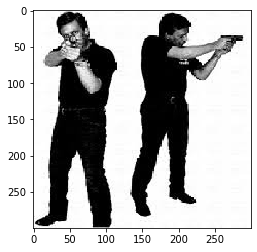

In [7]:
def show_image(n):
    
    print(f"Classes:{image_gen.class_indices}")
    plt.imshow(images[n])
    print(labels[n])
    
show_image(80)

## Train and Test Split

In [8]:
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.2, random_state=41)
X_model.shape, X_test.shape, y_model.shape, y_test.shape

((1276, 300, 300, 3), (320, 300, 300, 3), (1276, 6), (320, 6))

## Validation Set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=41)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1020, 300, 300, 3), (256, 300, 300, 3), (1020, 6), (256, 6))

In [10]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))
cnn.add(keras.layers.Dense(2, activation='softmax'))

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [12]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [13]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [14]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [15]:
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                5760032   
__________

In [28]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=400,
               batch_size=100,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1020 samples, validate on 256 samples
Epoch 1/1
1020/1020 [==============================] - 183s 179ms/step - loss: 0.4046 - acc: 0.8407 - val_loss: 0.3658 - val_acc: 0.8548


In [29]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

320/320 [==============================] - 12s 37ms/step
[0.3659849934718188, 0.8552287291078007] [0.3586286872625351, 0.8609374642372132]
